# Multi-Model Merging via Spherical Barycenters (SLERP per n > 2)

Obiettivi:
1) **Baricentro sferico** (media di Frechet su S^(d-1)) per fondere **n** modelli.
2) Confronti su MNIST con baseline: **SLERP chain**, **interpolazione lineare chain**, **ensemble ingenuo**.
3) Geometria: **PCA 2D**, **distanze angolari**, **simplex n=3**.
4) **Cycle-consistency**: test e consenso tra percorsi.




## Setup & Import

In [ ]:
# !pip install -q --upgrade scipy scikit-learn torchvision torchmetrics

import math, os, random, time, json
from typing import List, Dict, Tuple

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

from scipy.optimize import linear_sum_assignment
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
CKPT_DIR = "./checkpoints"
os.makedirs(CKPT_DIR, exist_ok=True)

print(f"Device: {DEVICE}")

Device: cpu


## Dati: MNIST

In [ ]:
BATCH_SIZE = 128

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,)),
])

train_ds = datasets.MNIST(root="./data", train=True, download=True, transform=transform)
test_ds  = datasets.MNIST(root="./data", train=False, download=True, transform=transform)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True)
test_loader  = DataLoader(test_ds,  batch_size=512, shuffle=False, num_workers=2, pin_memory=True)

len(train_ds), len(test_ds)

100%|██████████| 9.91M/9.91M [00:00<00:00, 56.3MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 1.61MB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 14.6MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 9.25MB/s]


(60000, 10000)

## Modello: MLP semplice

In [ ]:
class SimpleMLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(28*28, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 10)

    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

def build_model():
    return SimpleMLP()

## Training & Valutazione

In [ ]:
def train_model(model: nn.Module, train_loader, epochs=10, lr=1e-2, device=DEVICE, seed=None):
    if seed is not None:
        torch.manual_seed(seed); np.random.seed(seed); random.seed(seed)
    model = model.to(device)
    opt = torch.optim.SGD(model.parameters(), lr=lr, momentum=0.9)
    criterion = nn.CrossEntropyLoss()
    model.train()
    for ep in range(epochs):
        tot, corr, loss_sum = 0, 0, 0.0
        for x, y in train_loader:
            x, y = x.to(device), y.to(device)
            opt.zero_grad()
            logits = model(x)
            loss = criterion(logits, y)
            loss.backward()
            opt.step()
            loss_sum += loss.item() * y.size(0)
            corr += (logits.argmax(1) == y).sum().item()
            tot += y.size(0)
        print(f"[Epoch {ep+1}/{epochs}] loss={loss_sum/tot:.4f} acc={corr/tot:.4f}")
    return model

@torch.no_grad()
def evaluate_model(model: nn.Module, loader, device=DEVICE) -> float:
    model = model.to(device)
    model.eval()
    corr, tot = 0, 0
    for x, y in loader:
        x, y = x.to(device), y.to(device)
        logits = model(x)
        corr += (logits.argmax(1) == y).sum().item()
        tot += y.size(0)
    acc = corr / tot
    print(f"Accuracy: {acc*100:.2f}%")
    return acc

## Utility: flatten/unflatten & vectorizzazione pesi

In [ ]:
def flatten_tensor(t: torch.Tensor) -> torch.Tensor:
    return t.reshape(-1)

def l2norm(v: torch.Tensor, eps=1e-12) -> torch.Tensor:
    return v / (v.norm() + eps)

def state_dict_to_vector(sd: Dict[str, torch.Tensor], include_bias=True, normalize=True) -> torch.Tensor:
    vecs = []
    for k, t in sd.items():
        if not t.is_floating_point():
            continue
        if (("bias" in k) and (not include_bias)) or ("num_batches_tracked" in k):
            continue
        v = flatten_tensor(t.detach().cpu())
        if normalize:
            v = l2norm(v)
        vecs.append(v)
    if not vecs:
        return torch.zeros(1)
    return torch.cat(vecs, dim=0)

def vector_distance(a: Dict[str, torch.Tensor], b: Dict[str, torch.Tensor]) -> float:
    s = 0.0
    for k in a:
        if k in b and a[k].dtype.is_floating_point and b[k].dtype.is_floating_point:
            s += torch.sum((a[k].detach().cpu() - b[k].detach().cpu())**2).item()
    return math.sqrt(s)

## Geometria su S^(d-1): log/exp map e baricentro (media di Frechet)

In [ ]:
def slerp(v1: torch.Tensor, v2: torch.Tensor, alpha: float, eps=1e-8) -> torch.Tensor:
    v1 = l2norm(v1)
    v2 = l2norm(v2)
    dot = torch.clamp(torch.dot(v1, v2), -1.0, 1.0)
    th = torch.acos(dot)
    if th < eps:
        return (1.0 - alpha) * v1 + alpha * v2
    sin_t = torch.sin(th)
    return (torch.sin((1.0 - alpha) * th) / sin_t) * v1 + (torch.sin(alpha * th) / sin_t) * v2

def log_map(x: torch.Tensor, y: torch.Tensor, eps=1e-8) -> torch.Tensor:
    # T_x S^(d-1) <- log_x(y)
    x = l2norm(x); y = l2norm(y)
    c = torch.clamp(torch.dot(x, y), -1.0, 1.0)
    th = torch.acos(c)
    if th < eps:
        return torch.zeros_like(x)
    u = y - c * x
    denom = torch.norm(u) + eps
    u = u / denom
    return th * u

def exp_map(x: torch.Tensor, v: torch.Tensor, eps=1e-8) -> torch.Tensor:
    # S^(d-1) <- exp_x(v)
    x = l2norm(x)
    nv = torch.norm(v)
    if nv < eps:
        return x
    return torch.cos(nv) * x + torch.sin(nv) * (v / nv)

def spherical_frechet_mean(vectors: List[torch.Tensor],
                           weights: List[float] = None,
                           max_iter: int = 200,
                           tol: float = 1e-7,
                           step: float = 1.0,
                           verbose: bool = False) -> torch.Tensor:
    # Karcher mean su S^(d-1) per vettori unitari
    assert len(vectors) > 0
    vecs = [l2norm(v.detach().cpu().clone()) for v in vectors]
    n = len(vecs)
    if weights is None:
        w = torch.ones(n) / n
    else:
        w = torch.tensor(weights, dtype=torch.float)
        w = w / (w.sum() + 1e-12)

    # init: media euclidea normalizzata
    m = l2norm(sum((w[i] * vecs[i] for i in range(n)), torch.zeros_like(vecs[0])))

    def energy(mv):
        angs = []
        for i in range(n):
            c = torch.clamp(torch.dot(mv, vecs[i]), -1.0, 1.0)
            th = torch.acos(c)
            angs.append((w[i] * th * th).item())
        return float(sum(angs))

    prev_E = energy(m)
    for it in range(max_iter):
        grad = torch.zeros_like(m)
        for i in range(n):
            grad = grad + w[i] * log_map(m, vecs[i])
        gnorm = torch.norm(grad).item()
        if gnorm < tol:
            if verbose: print(f"[Karcher] stop at {it}, ||grad||={gnorm:.3e}")
            break
        eta = step
        for _ in range(10):
            cand = exp_map(m, eta * grad)
            E = energy(cand)
            if E <= prev_E - 1e-12:
                m = cand
                prev_E = E
                break
            eta *= 0.5
        else:
            m = exp_map(m, 0.1 * grad)
            prev_E = energy(m)
    return l2norm(m)

## Allineamento (Re-Basin) tra MLP

In [ ]:
def clone_model(model: nn.Module) -> nn.Module:
    m = SimpleMLP()
    m.load_state_dict(model.state_dict())
    return m

def rebasin_to_reference(model_src: nn.Module, model_ref: nn.Module) -> nn.Module:
    aligned = clone_model(model_src)

    # fc1: allinea righe (neuroni)
    W1_src = aligned.fc1.weight.data.detach().cpu().numpy()
    W1_ref = model_ref.fc1.weight.data.detach().cpu().numpy()
    cost1 = np.linalg.norm(W1_src[:, None, :], axis=2)**2 \
          + np.linalg.norm(W1_ref[None, :, :], axis=2)**2 \
          - 2.0 * (W1_src @ W1_ref.T)
    row1, col1 = linear_sum_assignment(cost1)
    aligned.fc1.weight.data = torch.tensor(W1_src[row1], device=aligned.fc1.weight.device)
    aligned.fc1.bias.data   = aligned.fc1.bias.data[row1]

    # Propaga permutazione row1 alle colonne di fc2
    W2 = aligned.fc2.weight.data.detach().cpu().numpy()
    W2 = W2[:, row1]
    aligned.fc2.weight.data = torch.tensor(W2, device=aligned.fc2.weight.device)

    # fc2: allinea righe
    W2_src = aligned.fc2.weight.data.detach().cpu().numpy()
    W2_ref = model_ref.fc2.weight.data.detach().cpu().numpy()
    cost2 = np.linalg.norm(W2_src[:, None, :], axis=2)**2 \
          + np.linalg.norm(W2_ref[None, :, :], axis=2)**2 \
          - 2.0 * (W2_src @ W2_ref.T)
    row2, col2 = linear_sum_assignment(cost2)
    aligned.fc2.weight.data = torch.tensor(W2_src[row2], device=aligned.fc2.weight.device)
    aligned.fc2.bias.data   = aligned.fc2.bias.data[row2]

    # Propaga permutazione row2 alle colonne di fc3
    W3 = aligned.fc3.weight.data.detach().cpu().numpy()
    W3 = W3[:, row2]
    aligned.fc3.weight.data = torch.tensor(W3, device=aligned.fc3.weight.device)
    return aligned

## Merge su state_dict: Interpolazioni e Baricentro Sferico (layer-wise)

In [ ]:
def is_running_stat(key: str) -> bool:
    return any(kw in key for kw in ["running_mean", "running_var", "num_batches_tracked"])

def linear_interpolate_state_dict(sd1: Dict[str, torch.Tensor], sd2: Dict[str, torch.Tensor], alpha: float) -> Dict[str, torch.Tensor]:
    out = {}
    for k in sd1.keys():
        if k not in sd2:
            continue
        t1, t2 = sd1[k], sd2[k]
        if not (t1.dtype.is_floating_point and t2.dtype.is_floating_point):
            out[k] = t1.clone()
            continue
        out[k] = (1.0 - alpha) * t1 + alpha * t2
    return out

def slerp_tensors(t1: torch.Tensor, t2: torch.Tensor, alpha: float, eps=1e-8) -> torch.Tensor:
    v1 = flatten_tensor(t1).detach().cpu()
    v2 = flatten_tensor(t2).detach().cpu()
    n1 = v1.norm() + eps
    n2 = v2.norm() + eps
    if n1 < eps and n2 < eps:
        return torch.zeros_like(t1)
    if n1 < eps:
        return alpha * t2
    if n2 < eps:
        return (1.0 - alpha) * t1
    u1 = v1 / n1
    u2 = v2 / n2
    u = slerp(u1, u2, alpha)
    n = (1.0 - alpha) * n1 + alpha * n2
    out = (u * n).reshape(t1.shape)
    return out.to(t1.device).type_as(t1)

def slerp_state_dict(sd1: Dict[str, torch.Tensor], sd2: Dict[str, torch.Tensor], alpha: float) -> Dict[str, torch.Tensor]:
    out = {}
    for k in sd1.keys():
        if k not in sd2:
            continue
        t1, t2 = sd1[k], sd2[k]
        if is_running_stat(k) or ('bias' in k) or (not (t1.dtype.is_floating_point and t2.dtype.is_floating_point)):
            out[k] = (1.0 - alpha) * t1 + alpha * t2
        else:
            out[k] = slerp_tensors(t1, t2, alpha)
    return out

def barycenter_tensors(tensors: List[torch.Tensor], weights: List[float] = None) -> torch.Tensor:
    vs = []
    norms = []
    eps = 1e-8
    for t in tensors:
        v = flatten_tensor(t).detach().cpu()
        n = v.norm() + eps
        norms.append(n)
        if n < eps:
            v = torch.zeros_like(v); v[0] = 1.0; n = v.norm()
        vs.append(v / n)
    w = None
    if weights is not None:
        w = weights
    u_star = spherical_frechet_mean(vs, weights=w, max_iter=200, tol=1e-7, step=1.0, verbose=False)
    norms = torch.tensor(norms, dtype=torch.float)
    if weights is None:
        n_bar = norms.mean().item()
    else:
        w_t = torch.tensor(weights, dtype=torch.float)
        n_bar = float((w_t / (w_t.sum() + 1e-12) * norms).sum().item())
    out = (u_star * n_bar).reshape(tensors[0].shape)
    return out.to(tensors[0].device).type_as(tensors[0])

def barycenter_state_dicts(sds: List[Dict[str, torch.Tensor]], weights: List[float] = None) -> Dict[str, torch.Tensor]:
    keys = sds[0].keys()
    out = {}
    for k in keys:
        tlist = [sd[k] for sd in sds if k in sd]
        if not tlist:
            continue
        t0 = tlist[0]
        if is_running_stat(k) or ('bias' in k) or (not t0.dtype.is_floating_point):
            if weights is None:
                out[k] = sum(tlist) / len(tlist)
            else:
                w = torch.tensor(weights, dtype=torch.float, device=t0.device)
                w = w / (w.sum() + 1e-12)
                tt = torch.stack([t.to(t0.device) for t in tlist], dim=0)
                out[k] = (w.view(-1, *([1] * (tt.ndim - 1))) * tt).sum(dim=0)
        else:
            out[k] = barycenter_tensors(tlist, weights)
    return out

## Ensemble ingenuo (media logits)

In [ ]:
@torch.no_grad()
def ensemble_accuracy(models: List[nn.Module], loader, device=DEVICE) -> float:
    for m in models:
        m.to(device).eval()
    corr, tot = 0, 0
    for x, y in loader:
        x, y = x.to(device), y.to(device)
        logits_sum = None
        for m in models:
            l = m(x)
            logits_sum = l if logits_sum is None else logits_sum + l
        preds = logits_sum.argmax(1)
        corr += (preds == y).sum().item()
        tot += y.size(0)
    acc = corr / tot
    print(f"Ensemble accuracy: {acc*100:.2f}%")
    return acc

## Training di piu modelli e salvataggio checkpoint

In [ ]:
def save_ckpt(model: nn.Module, path: str):
    torch.save(model.state_dict(), path)

def load_ckpt(path: str) -> nn.Module:
    m = build_model()
    m.load_state_dict(torch.load(path, map_location="cpu"))
    return m

def train_multiple_models(K=3, epochs=10, lr=1e-2, base_seed=0) -> List[str]:
    paths = []
    for i in range(K):
        seed = base_seed + i
        print(f"\n===> Training model {i} (seed={seed})")
        m = build_model()
        train_model(m, train_loader, epochs=epochs, lr=lr, seed=seed, device=DEVICE)
        p = os.path.join(CKPT_DIR, f"mnist_mlp_seed{seed}.pt")
        save_ckpt(m.cpu(), p)
        paths.append(p)
    return paths

## Funzioni esperimento di merge

In [ ]:
def make_models_from_paths(paths: List[str]) -> List[nn.Module]:
    return [load_ckpt(p) for p in paths]

def align_models_to_ref(models: List[nn.Module], ref_idx=0) -> List[nn.Module]:
    ref = models[ref_idx]
    out = []
    for i, m in enumerate(models):
        if i == ref_idx:
            out.append(m)
        else:
            out.append(rebasin_to_reference(m, ref))
    return out

def build_model_from_sd(sd: Dict[str, torch.Tensor]) -> nn.Module:
    m = build_model()
    m.load_state_dict(sd)
    return m

def evaluate_state_dict(sd: Dict[str, torch.Tensor], loader) -> float:
    m = build_model_from_sd(sd)
    return evaluate_model(m, loader)

def experiment_merge(paths: List[str], do_align=True):
    models = make_models_from_paths(paths)
    if do_align:
        print("\n[Re-Basin] Allineo modelli al riferimento (0)...")
        models_aligned = align_models_to_ref(models, ref_idx=0)
    else:
        models_aligned = models

    print("\n[Eval] Modelli singoli")
    single_accs = []
    for i, m in enumerate(models_aligned):
        a = evaluate_model(m, test_loader)
        single_accs.append(a)

    ens_acc = ensemble_accuracy(models_aligned, test_loader)
    sds = [m.state_dict() for m in models_aligned]

    results = []
    print("\n[Merge] Barycenter n (uniforme)")
    sd_bary_u = barycenter_state_dicts(sds, weights=None)
    acc_bary_u = evaluate_state_dict(sd_bary_u, test_loader)
    results.append(("barycenter_uniform", acc_bary_u))

    if len(sds) >= 3:
        w = [0.6, 0.3, 0.1] + [0.0] * (len(sds) - 3)
        w = w[:len(sds)]
        print(f"\n[Merge] Barycenter n (pesato={w})")
        sd_bary_w = barycenter_state_dicts(sds, weights=w)
        acc_bary_w = evaluate_state_dict(sd_bary_w, test_loader)
        results.append(("barycenter_weighted", acc_bary_w))

    print("\n[Merge] Pairwise SLERP chain")
    sd_chain = sds[0]
    for j in range(1, len(sds)):
        sd_chain = slerp_state_dict(sd_chain, sds[j], alpha=0.5)
    acc_chain = evaluate_state_dict(sd_chain, test_loader)
    results.append(("slerp_chain_0.5", acc_chain))

    print("\n[Merge] Interpolazione lineare chain")
    sd_lin = sds[0]
    for j in range(1, len(sds)):
        sd_lin = linear_interpolate_state_dict(sd_lin, sds[j], alpha=0.5)
    acc_lin = evaluate_state_dict(sd_lin, test_loader)
    results.append(("linear_chain_0.5", acc_lin))

    results.append(("ensemble_logits", ens_acc))

    import pandas as pd
    df = pd.DataFrame([{"method": "single_" + str(i), "acc": single_accs[i]} for i in range(len(single_accs))] +
                      [{"method": m, "acc": a} for (m, a) in results])
    print(df)

    # Spiegazione breve per ogni riga del risultato:
    explanations = {
        "barycenter_uniform": "Baricentro sferico n-ario con pesi uniformi (merge dei pesi su S^(d-1)).",
        "barycenter_weighted": "Baricentro sferico n-ario con pesi non uniformi (es. 0.6, 0.3, 0.1).",
        "slerp_chain_0.5": "Catena di SLERP pairwise con alpha=0.5 a ogni step (dipende dall'ordine).",
        "linear_chain_0.5": "Catena di interpolazioni lineari (euclidee) con alpha=0.5.",
        "ensemble_logits": "Ensemble ingenuo: media dei logits senza fondere i pesi.",
    }
    print("\nSpiegazione metodi:")
    for _, row in df.iterrows():
        m = row["method"]
        if m.startswith("single_"):
            print(f"- {m}: Accuratezza del modello singolo (seed specifico).")
        elif m in explanations:
            print(f"- {m}: {explanations[m]}")

    return df, models_aligned, sds, sd_bary_u, sd_chain

## Geometria: PCA 2D e distanze angolari

In [ ]:
def angular_distance(u: torch.Tensor, v: torch.Tensor) -> float:
    u = l2norm(u); v = l2norm(v)
    c = torch.clamp(torch.dot(u, v), -1.0, 1.0)
    return float(torch.acos(c).item())

def pca_plot_models(state_dicts: List[Dict[str, torch.Tensor]], labels: List[str]):
    vecs = [state_dict_to_vector(sd, include_bias=True, normalize=True) for sd in state_dicts]
    X = torch.stack(vecs).numpy()
    pca = PCA(n_components=2)
    X2 = pca.fit_transform(X)

    plt.figure()
    for i, (x, y) in enumerate(X2):
        plt.scatter(x, y)
        plt.text(x, y, labels[i])
    plt.title("PCA (2D) dei vettori pesi unitari")
    plt.xlabel("PC1"); plt.ylabel("PC2")
    plt.show()

    n = len(vecs)
    M = np.zeros((n, n), dtype=float)
    for i in range(n):
        for j in range(n):
            M[i, j] = angular_distance(vecs[i], vecs[j])
    import pandas as pd
    df = pd.DataFrame(M, index=labels, columns=labels)
    print("Distanze angolari (radiani):")
    print(df.round(4))
    return df

## Cycle consistency (path-independence) – Test e consenso

In [ ]:
def state_dict_distance(sd1: Dict[str, torch.Tensor], sd2: Dict[str, torch.Tensor]) -> float:
    return vector_distance(sd1, sd2)

def cycle_consistency_test(
    sds: List[Dict[str, torch.Tensor]],
    sd_bary: Dict[str, torch.Tensor],
    sd_chain: Dict[str, torch.Tensor],
    enforce: bool = True,
    alpha_chain: float = 0.5,
    max_paths: int = 6,
    return_sd: bool = True,
):
    import itertools, random

    K = len(sds)
    idxs = list(range(K))

    def slerp_chain_by_order(order):
        sd = sds[order[0]]
        for j in order[1:]:
            sd = slerp_state_dict(sd, sds[j], alpha=alpha_chain)
        return sd

    orders = []
    if K <= 5:
        orders = list(itertools.permutations(idxs))
        if max_paths is not None and len(orders) > max_paths:
            random.seed(123)
            orders = random.sample(orders, max_paths)
    else:
        random.seed(123)
        orders = [tuple(random.sample(idxs, K)) for _ in range(max_paths)]

    base = tuple(range(K))
    if base not in orders:
        orders = [base] + orders

    path_state_dicts = []
    dists_to_bary = []
    for ordk in orders:
        sd_path = slerp_chain_by_order(ordk)
        path_state_dicts.append(sd_path)
        d = vector_distance(sd_path, sd_bary)
        dists_to_bary.append(d)

    d_chain = vector_distance(sd_chain, sd_bary)

    d_arr = np.array(dists_to_bary, dtype=float)
    stats = {
        "num_paths": len(orders),
        "min_dist": float(d_arr.min() if len(d_arr)>0 else 0.0),
        "max_dist": float(d_arr.max() if len(d_arr)>0 else 0.0),
        "mean_dist": float(d_arr.mean() if len(d_arr)>0 else 0.0),
        "std_dist": float(d_arr.std(ddof=0) if len(d_arr)>0 else 0.0),
    }

    print(f"|| barycenter - slerp_chain(base) ||_2 = {d_chain:.4f}")
    print(f"[paths={stats['num_paths']}] dist(path, bary): "
          f"min={stats['min_dist']:.4f}, max={stats['max_dist']:.4f}, "
          f"mean={stats['mean_dist']:.4f} ± {stats['std_dist']:.4f}")

    if enforce:
        sds_consensus = [sd_bary] + path_state_dicts
        weights = None  # oppure: [2.0] + [1.0]*len(path_state_dicts) per dare piu peso a sd_bary
        sd_cc = barycenter_state_dicts(sds_consensus, weights=weights)
        d_cc_bary = vector_distance(sd_cc, sd_bary)
        d_cc_chain = vector_distance(sd_cc, sd_chain)
        print(f"Consensus merge: ||cc - bary||_2 = {d_cc_bary:.4f},  ||cc - chain(base)||_2 = {d_cc_chain:.4f}")
        if return_sd:
            return d_chain, stats, sd_cc
        else:
            return d_chain, stats

    return d_chain, stats

## Simplex per n=3: campionamento pesi e mappa prestazioni

In [ ]:
def barycentric_to_cartesian(w1, w2, w3):
    A = np.array([0.0, 0.0])
    B = np.array([1.0, 0.0])
    C = np.array([0.5, math.sqrt(3)/2.0])
    return w1*A + w2*B + w3*C

def simplex_scan_n3(sds: List[Dict[str, torch.Tensor]], steps=4):
    assert len(sds) >= 3, "Servono almeno 3 modelli"
    pts = []
    accs = []
    for i in range(steps+1):
        for j in range(steps+1 - i):
            k = steps - i - j
            w = np.array([i, j, k], dtype=float) / steps
            w = w.tolist()
            sd_b = barycenter_state_dicts(sds[:3], weights=w)
            acc = evaluate_state_dict(sd_b, test_loader)
            x, y = barycentric_to_cartesian(*w)
            pts.append((x, y))
            accs.append(acc)
    xs = [p[0] for p in pts]
    ys = [p[1] for p in pts]
    plt.figure()
    sc = plt.scatter(xs, ys, c=accs)
    plt.title("Accuracy sul simplex dei pesi (n=3)")
    plt.xlabel("x"); plt.ylabel("y")
    plt.colorbar(sc, label="Accuracy")
    plt.show()

## Esecuzione demo


===> Training model 0 (seed=0)


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


[Epoch 1/10] loss=0.4388 acc=0.8706
[Epoch 2/10] loss=0.1608 acc=0.9526
[Epoch 3/10] loss=0.1103 acc=0.9669
[Epoch 4/10] loss=0.0836 acc=0.9749
[Epoch 5/10] loss=0.0666 acc=0.9801
[Epoch 6/10] loss=0.0539 acc=0.9838
[Epoch 7/10] loss=0.0450 acc=0.9861
[Epoch 8/10] loss=0.0369 acc=0.9890
[Epoch 9/10] loss=0.0302 acc=0.9912
[Epoch 10/10] loss=0.0248 acc=0.9929

===> Training model 1 (seed=1)
[Epoch 1/10] loss=0.4643 acc=0.8678
[Epoch 2/10] loss=0.1647 acc=0.9510
[Epoch 3/10] loss=0.1117 acc=0.9662
[Epoch 4/10] loss=0.0841 acc=0.9754
[Epoch 5/10] loss=0.0664 acc=0.9804
[Epoch 6/10] loss=0.0543 acc=0.9838
[Epoch 7/10] loss=0.0442 acc=0.9869
[Epoch 8/10] loss=0.0376 acc=0.9887
[Epoch 9/10] loss=0.0307 acc=0.9909
[Epoch 10/10] loss=0.0247 acc=0.9929

===> Training model 2 (seed=2)
[Epoch 1/10] loss=0.4348 acc=0.8721
[Epoch 2/10] loss=0.1605 acc=0.9527
[Epoch 3/10] loss=0.1095 acc=0.9671
[Epoch 4/10] loss=0.0822 acc=0.9759
[Epoch 5/10] loss=0.0656 acc=0.9807
[Epoch 6/10] loss=0.0545 acc=0.983

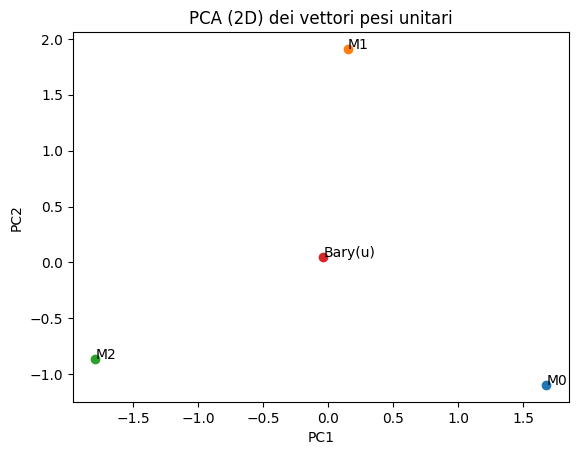

Distanze angolari (radiani):
             M0      M1      M2  Bary(u)
M0       0.0003  1.5180  1.5800   0.9707
M1       1.5180  0.0000  1.5279   0.8986
M2       1.5800  1.5279  0.0000   0.9401
Bary(u)  0.9707  0.8986  0.9401   0.0000
|| barycenter - slerp_chain(base) ||_2 = 2.3070
[paths=6] dist(path, bary): min=2.3026, max=2.3127, mean=2.3074 ± 0.0041
Consensus merge: ||cc - bary||_2 = 0.0013,  ||cc - chain(base)||_2 = 2.3075

[Eval] Cycle-consistent consensus merge


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Accuracy: 52.74%
Accuracy (cycle-consistent): 52.74%
Accuracy: 97.99%
Accuracy: 93.74%
Accuracy: 73.24%
Accuracy: 94.62%
Accuracy: 97.70%
Accuracy: 94.07%
Accuracy: 67.10%
Accuracy: 67.33%
Accuracy: 94.07%
Accuracy: 74.46%
Accuracy: 65.14%
Accuracy: 79.18%
Accuracy: 92.64%
Accuracy: 94.56%
Accuracy: 97.74%


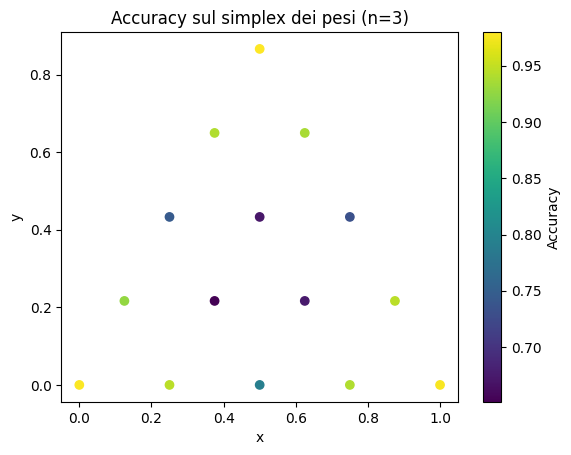

In [ ]:
# Parametri demo
K = 3          # >=3 per vedere barycenter n>2 e simplex
EPOCHS = 10    # imposta a 5 o 10; modelli piu simili e piu forti
LR = 1e-2
BASE_SEED = 0

# 1) Allena K modelli (usa checkpoint se gia esistono)
paths = []
for i in range(K):
    p = os.path.join(CKPT_DIR, f"mnist_mlp_seed{BASE_SEED+i}.pt")
    if not os.path.exists(p):
        break
    paths.append(p)

if len(paths) != K:
    paths = train_multiple_models(K=K, epochs=EPOCHS, lr=LR, base_seed=BASE_SEED)

# 2) Esperimenti di merge (con re-basin)
df_res, models_aligned, sds_aligned, sd_bary_u, sd_chain = experiment_merge(paths, do_align=True)

# 3) PCA e distanze
labels = [f"M{i}" for i in range(len(sds_aligned))] + ["Bary(u)"]
pca_plot_models(sds_aligned + [sd_bary_u], labels)

# 4) Ciclo-consistenza (nuova versione con enforcement)
d_chain, stats, sd_cc = cycle_consistency_test(
    sds_aligned,
    sd_bary=sd_bary_u,
    sd_chain=sd_chain,
    enforce=True,
    alpha_chain=0.5,
    max_paths=6,
    return_sd=True,
)

# Valuta anche il modello cycle-consistent
print("\n[Eval] Cycle-consistent consensus merge")
acc_cc = evaluate_state_dict(sd_cc, test_loader)
print(f"Accuracy (cycle-consistent): {acc_cc*100:.2f}%")

# 5) Simplex n=3 (ATTIVO)
simplex_scan_n3(sds_aligned, steps=4)